### __Prepare the Environment__

 __import the libraries__

In [1]:
!pip install facenet-pytorch

In [2]:
import shutil
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import torch

from facenet_pytorch import MTCNN, InceptionResnetV1
from IPython.display import Video
from PIL import Image
from torch.utils.data import DataLoader
from torchvision import datasets


check if GPU is available.

In [3]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(f"Using {device} device.")

Using cuda device.


### __Exploring the Video__

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


We've download the YouTube video (`https://www.youtube.com/watch?v=73fz_uK-vhs`) to directory `"data"`, so let's start by preparing that.

**Task 4.7.1:** Create a path object for the `"data"` directory. Use the `Path` class from `pathlib`.

In [5]:
curr_work_dir = Path.cwd()
print(curr_work_dir)


/content


**Task 4.7.3:** Create a variable for the video file path using `pathlib` syntax.

In [6]:
input_video = Path("/content/drive/My Drive/Celebrity Sightings in India/Assignment/lupita_nyongo.mp4")


print(f"Path to images: {input_video}")

Path to images: /content/drive/My Drive/Celebrity Sightings in India/Assignment/lupita_nyongo.mp4


Let's look at the video.

In [7]:
# Display the video
Video(input_video, width=400)




# Display the video
from IPython.display import Video

input_video = "/content/drive/My Drive/Celebrity Sightings in India/Assignment/lupita_nyongo.mp4"
Video(input_video, embed=True, width=600)

Output hidden; open in https://colab.research.google.com to view.

In the video Lupita Nyong'o wins an Oscar, awarded to her by Christoph Waltz. He's an Oscar-winning Austrian-German actor.

Let's use this video for face detection and face recognition! We'll use Lupita and Christoph's faces from this video and compute their faceprints. Then we'll use those faceprints and test if we can recognize Lupita and Christoph on some test images.

### __Prepare Images From Video__

First thing we need to do is extract individual frames from the video.

**Task 4.7.4:** Create a directory path for the extracted frames using the `pathlib` syntax. This path should be a directory called `extracted_frames` which should be in `data_dir`.

In [8]:
frames_dir = Path("/content/drive/My Drive/Celebrity Sightings in India/Assignment/extracted_frames")

frames_dir.mkdir(parents=True, exist_ok=True)  # Creates the directory if it doesn't exist
print(frames_dir)

/content/drive/My Drive/Celebrity Sightings in India/Assignment/extracted_frames


Next let's create a video capture and compute the frame rate.

In [9]:
video_capture = cv2.VideoCapture(input_video)
frame_rate = round(video_capture.get(cv2.CAP_PROP_FPS))

print(f"Frame rate: {frame_rate}")

Frame rate: 30


Now we're ready to extract individual frames!

**Task 4.7.5:** Fill in the missing code below that saves every sixth frame from the video.

In [10]:
interval = 6  # Extract every sixth frame from the video
frame_count = 0

print("Start extracting individual frames...")
while True:
    # read the next frame from the video_capture
    ret, frame = video_capture.read()
    if not ret:
        print("Finished!")
        break  # Break the loop if there are no more frames

    # Save frames at every 'interval' frames
    if frame_count % interval == 0:
        frame_path = frames_dir / f"frame_{frame_count}.jpg"
        cv2.imwrite(frame_path, frame)

    frame_count += 1

video_capture.release()


Start extracting individual frames...
Finished!


Great! We ultimately want to use this data to compute a faceprint (face embedding) of Lupita Nyong'o and Christoph Waltz, so we can then identify them in other images. In order to compute their faceprints, we'll need a directory of images with Lupita and a directory or images with Christoph.

To store these selected images, let's make a directory `images` within the `data` directory.

In [11]:
images_dir = Path("/content/drive/My Drive/Celebrity Sightings in India/Assignment/images")

images_dir.mkdir(parents=True, exist_ok=True)  # Creates the directory if it doesn't exist
print(images_dir)

/content/drive/My Drive/Celebrity Sightings in India/Assignment/images


**Task 4.7.6:** Make a subdirectory in the `images` directory and call it `lupita`. Then do the same for a directory called `christoph`.

In [12]:
lupita_dir = images_dir / "lupita"
# Now create `lupita` directory
lupita_dir.mkdir(exist_ok=True)

christoph_dir = images_dir / "christoph"
# Now create `christoph` directory
christoph_dir.mkdir(exist_ok=True)

Below are the selected frames we'll use for each of our two individuals.

In [13]:
lupita_imgs = [
    "frame_3438.jpg",
    "frame_3486.jpg",
    "frame_3852.jpg",
    "frame_4062.jpg",
    "frame_4914.jpg",
    "frame_4866.jpg",
]

christoph_imgs = [
    "frame_54.jpg",
    "frame_66.jpg",
    "frame_72.jpg",
    "frame_108.jpg",
    "frame_186.jpg",
    "frame_246.jpg",
]

**Task 4.7.7:** Iterate over `lupita_imgs` and create a list of paths to each image using `pathlib` syntax. Do the same for the selected images in `christoph_imgs`.

In [14]:
lupita_img_paths = [frames_dir / i for i in lupita_imgs]
christoph_img_paths = [frames_dir / i for i in christoph_imgs]

print("Number of Lupita images:", len(lupita_img_paths))
print("Number of Christoph images:", len(christoph_img_paths))


Number of Lupita images: 6
Number of Christoph images: 6


Let's look at both sets of selected images.

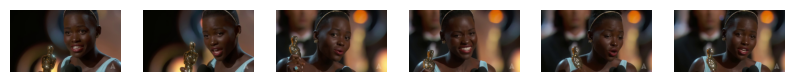

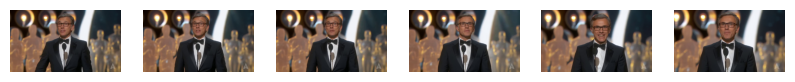

In [15]:
fig, axs = plt.subplots(1, 6, figsize=(10, 8))
for i, ax in enumerate(axs):
    ax.imshow(Image.open(lupita_img_paths[i]))
    ax.axis("off")

fig, axs = plt.subplots(1, 6, figsize=(10, 8))
for i, ax in enumerate(axs):
    ax.imshow(Image.open(christoph_img_paths[i]))
    ax.axis("off")

**Task 4.7.8:** Iterate over `lupita_img_paths` and copy the selected images into the `lupita` directory. Then iterate over `christoph_img_paths` and copy those selected images into the `christoph` directory.

In [16]:
# Copy selected images of Lupita over to `lupita` directory
for image_path in lupita_img_paths:
    shutil.copy(image_path, lupita_dir)

# Copy selected images of Christoph over to `christoph` directory
for image_path in christoph_img_paths:
    shutil.copy(image_path, christoph_dir)

print("Number of files in lupita directory:", len(list(lupita_dir.iterdir())))
print("Number of files in christoph directory:", len(list(christoph_dir.iterdir())))


Number of files in lupita directory: 6
Number of files in christoph directory: 6


### __Face Detection with MTCNN__

We'll first use a MTCNN model on one sample image and check the returned bounding boxes and facial landmarks.

**Task 4.7.9:** Initialize a MTCNN model. Let's keep all detected faces (so set `keep_all=True`). Use `min_face_size` to set minimum face size to search for to be 40.

In [17]:
mtcnn = MTCNN(keep_all=True, min_face_size=40)

print(f"MTCNN min face size: {mtcnn.min_face_size}")
print(f"MTCNN keeping all faces: {mtcnn.keep_all}")

MTCNN min face size: 40
MTCNN keeping all faces: True


We'll use this model on the following sample image.

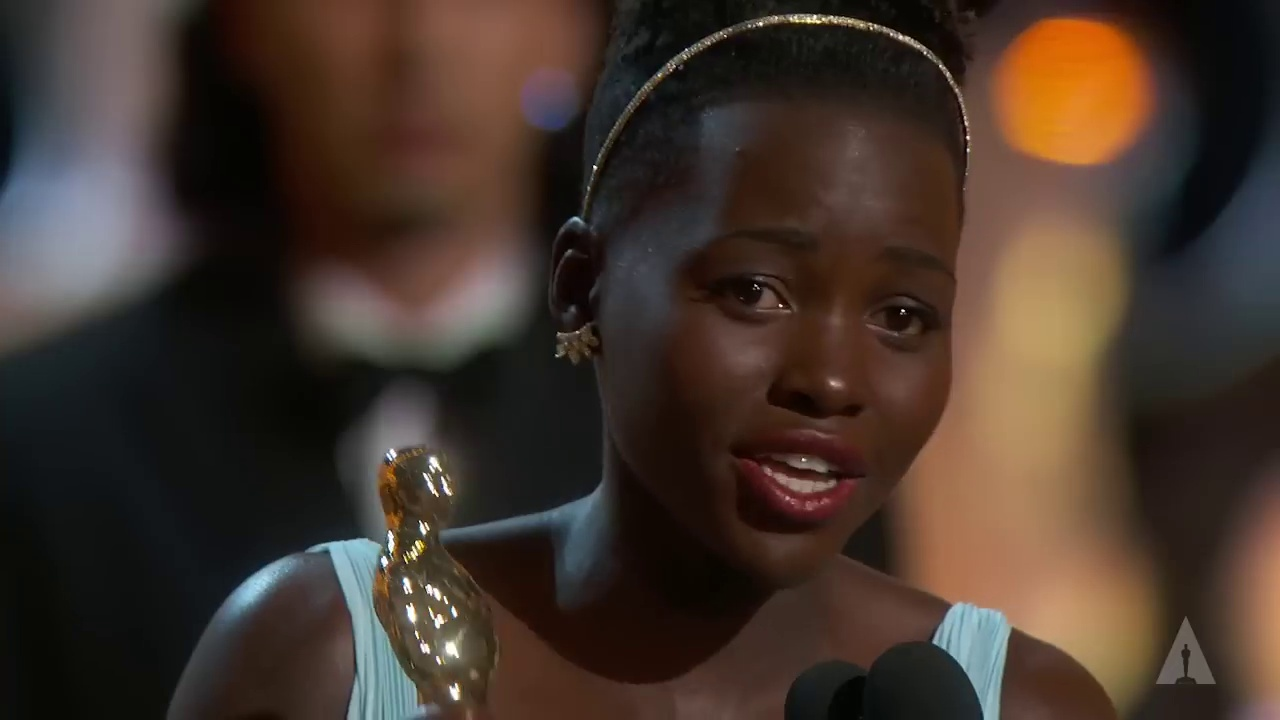

In [18]:
sample_image_filename = "frame_4866.jpg"
sample_image_path = frames_dir / sample_image_filename

sample_image = Image.open(sample_image_path)
sample_image

**Task 4.7.10:** Use the `detect` method of the MTCNN model you initialized above on the sample image. Make sure to get bounding boxes, probabilities and facial landmarks returned (you'll need `landmarks=True`).

In [19]:
boxes, probs, landmarks = mtcnn.detect(sample_image, landmarks=True)

print("boxes:", boxes)
print("probs:", probs)
print("landmarks:", landmarks)


boxes: [[641.1326293945312 116.50221252441406 961.9889526367188
  556.0637817382812]]
probs: [0.9997404217720032]
landmarks: [[[755.8956909179688 290.0362548828125]
  [905.3399658203125 316.55841064453125]
  [828.8113403320312 391.3585205078125]
  [738.5498657226562 451.2347717285156]
  [863.9264526367188 473.7735595703125]]]


Looks like a face was detected with very large probability!

**Task 4.7.11:** Fill in the missing code to plot the bounding box as well as the facial landmarks on top of the sample image. Use `zip` on `boxes` and `landmarks` in the `for` loop that you need to fill in.

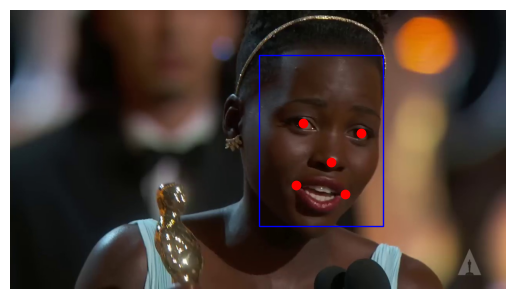

In [20]:
fig, ax = plt.subplots()
ax.imshow(sample_image)

for box, landmark in zip(boxes, landmarks):
    rect = plt.Rectangle(
        (box[0], box[1]), box[2] - box[0], box[3] - box[1], fill=False, color="blue"
    )
    ax.add_patch(rect)
    for point in landmark:
        ax.plot(point[0], point[1], marker="o", color="red")
plt.axis("off");


### __Face Recognition with Inception-ResNet V1 Model__

Now let's use Inception-ResNet V1 for face recognition.

**Task 4.7.12:** Initialize a Inception-ResNet V1 model. Use the one that has been pre-trained on the VGGFace2 dataset.

In [21]:
resnet = InceptionResnetV1(pretrained="vggface2").eval()

print(f"InceptionResnet weight set: {resnet.pretrained}")

  0%|          | 0.00/107M [00:00<?, ?B/s]

InceptionResnet weight set: vggface2


Next create an `ImageFolder` object for the `images_dir` path, where we have the `lupita` and `christopher` subdirectories.

**Task 4.7.13:** Create an `ImageFolder` object for the `images_dir` path.

In [22]:
dataset = datasets.ImageFolder(images_dir)

print(dataset)

Dataset ImageFolder
    Number of datapoints: 12
    Root location: /content/drive/My Drive/Celebrity Sightings in India/Assignment/images


The names of the two subdirectories in `images` directory (`lupita` and `christoph`) are the "classes" names. Looking ahead, it'll be useful to have a mapping between class index and class name, so let's do that.

**Task 4.7.14:** Create a dictionary that maps integer to class label. You can use `dataset.class_to_idx`.

In [23]:
idx_to_class = {i: c for c, i in dataset.class_to_idx.items()}

print(idx_to_class)


{0: 'christoph', 1: 'lupita'}


Similarly to what we did in lesson 4, we'll now construct a `DataLoader` object with the above created `dataset`.

In [24]:
def collate_fn(x):
    return x[0]


loader = DataLoader(dataset, collate_fn=collate_fn)
print(loader.dataset)

Dataset ImageFolder
    Number of datapoints: 12
    Root location: /content/drive/My Drive/Celebrity Sightings in India/Assignment/images


Now we're ready to compute the face embeddings of Lupita and Christoph's faces. On each image, we'll:

- Use the MTCNN model to detect the face
- Check if the model predicts a face with a probability of at least 90%
- If we have a face, run the Inception-ResNet V1 to get the face embedding
- Add the embedding to a dictionary that keeps the embeddings for each person separately

**Task 4.7.15:** Fill in the missing code below. Make sure to filter out results in which `face` is `None` or where the probability is less than 0.90.

In [29]:
# Dictionary that maps name to list of their embeddings
name_to_embeddings = {name: [] for name in idx_to_class.values()}

for img, idx in loader:
    face, prob = mtcnn(img, return_prob=True)

    # Ensure `prob` is a single scalar value before comparison
    # if face is not None and prob is not None and prob.item() >= 0.90:
    emb = resnet(face[0].unsqueeze(0))
    name_to_embeddings[idx_to_class[idx]].append(emb)

print(name_to_embeddings.keys())
print(type(name_to_embeddings["lupita"]))
print(type(name_to_embeddings["christoph"]))


dict_keys(['christoph', 'lupita'])
<class 'list'>
<class 'list'>


Well done, we have a list of face embeddings for each person! Now let's compute the average faceprint for each of them.

**Task 4.7.16:** For both Lupita and Christoph, take the list of embeddings and convert each list to a 2D PyTorch tensor by using `torch.stack`.

In [30]:
embeddings_lupita = torch.stack(name_to_embeddings["lupita"])
embeddings_christoph = torch.stack(name_to_embeddings["christoph"])

print(f"Shape of stack of embeddings for Lupita: {embeddings_lupita.shape}")
print(f"Shape of stack of embeddings for Christoph: {embeddings_christoph.shape}")


Shape of stack of embeddings for Lupita: torch.Size([6, 1, 512])
Shape of stack of embeddings for Christoph: torch.Size([6, 1, 512])


**Task 4.7.17:** Calculate the average of the stacked embeddings along the zero dimension using `torch.mean`.

In [31]:
avg_embedding_lupita = torch.mean(embeddings_lupita, dim=0)
avg_embedding_christoph = torch.mean(embeddings_christoph, dim=0)

print(f"Shape of avg_embedding_lupita: {avg_embedding_lupita.shape}")
print(f"Shape of avg_embedding_christoph: {avg_embedding_christoph.shape}")


Shape of avg_embedding_lupita: torch.Size([1, 512])
Shape of avg_embedding_christoph: torch.Size([1, 512])


We now have a faceprint for both Lupita and Christoph, so we can go ahead and test if we recognize either of them on some test images.

Here is the list of frames we'll test.

In [32]:
test_images = ["frame_2658.jpg", "frame_4614.jpg", "frame_972.jpg", "frame_30.jpg"]

**Task 4.7.18:** Create a list of test image paths. Remember that these test images are in `frames_dir`.

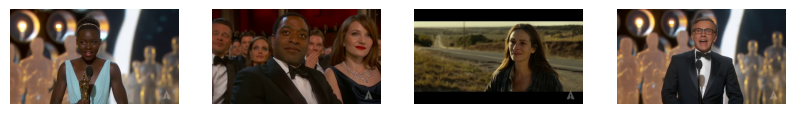

In [33]:
test_paths = [frames_dir / frame for frame in test_images]

fig, axs = plt.subplots(1, len(test_paths), figsize=(10, 8))
for i, ax in enumerate(axs):
    ax.imshow(Image.open(test_paths[i]))
    ax.axis("off")


In the lesson we defined the `recognize_faces` function.  We have placed that in the `utils.py` file here. Let's import it.

In [34]:
!pip install utils  # Might not work if it's a custom script

  Preparing metadata (setup.py) ... done
  Created wheel for utils: filename=utils-1.0.2-py2.py3-none-any.whl size=13906 sha256=71258f2d1ac6690575e41830baec086de137d640e6c965f90fd903b97732ea55
  Stored in directory: /root/.cache/pip/wheels/15/0c/b3/674aea8c5d91c642c817d4d630bd58faa316724b136844094d
Successfully built utils


As you can see from the function docstring, given an image path, this function:
- Runs the MTCNN model
- Computes a face embedding on each detected face
- Computes the distance between the obtained face embedding and the list of given embeddings
- Identifies if any face from the given list of embeddings is closer than the threshold
- Displays the image together with detected faces, identities and distances to determined identities